<div align="center" vertical-align="middle">
  <a><img height="200px" src="../../docs/scapy-logo-cropped.png"></a>
  <h1>Userguide for Conjunction Event forecasting</h1>
</div>



#### Table of contents
1. Environment set-up
2. Data preparation
    1. Importing events 
        1. From Kelvins Challenge competition.
        2. From pandas DataFrame.
    2. Importing events from external files and folders.
3. Conjunction Event forecasting model configuration
    1. Recurrent Neural Network configuration
    2. Model instanciation
4. Model loading, training and saving
    1. Loading model
    2. Training model
    3. Saving model
5. Evaluating models performance using the Test dataset
6. Using the model to forecast Conjunction Events


## 1.- Environment set-up

In [16]:
# Get current working directory path for the tool parent folder and add it to the system path
from pathlib import Path
import os
foldername = 'scapy'
cwd = str(Path(os.getcwd()[:os.getcwd().index(foldername)+len(foldername)]))

# Add library path to system path if it is not included already.
import sys
if cwd not in sys.path: sys.path.append(cwd)
print(f'Current working directory: {cwd}')

# Import utils library containing miscellaneous functions/classes
from scapy import utils

# Set overall seed for reproducibility
utils.seed(1)

# Show plots in the notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
rc('text', usetex=True)


Current working directory: /Users/jjrr/Documents/SCA-Project/scapy


## 2.- Data preparation

### 2.1.- Importing events

#### 2.1.1.- From [Kelvins Challenge competition](https://kelvins.esa.int/collision-avoidance-challenge/data/)

In [2]:
# Use data from Kelvins competition:
# https://kelvins.esa.int/collision-avoidance-challenge/data/

# Import library to import Kelvins challlenge data
from scapy.data import kelvins_challenge_events

# Download data from Kelvins website
filepath = utils.download_kelvins_data(data = 'train', return_filepath = True)

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(
            filepath = filepath,                # Local CSV file path to import
            num_events = 2000,                  # Number of events to import
            date_tca = None,                    # TCA date as reference
            remove_outliers = True,             # Remove outliers
            drop_features = ['c_rcs_estimate',  # Columns to exclude
                             't_rcs_estimate'],
            print_log = False                   # Show progress of import 
            )

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scapy/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:12s |  155.17   | Dataset imported (2000 events).         


#### 2.1.2.- From generic pandas DataFrame

In [3]:
# # A generic loading method can be used to import events from a pandas DataFrame:
# # Required class and libraries for this method.
# import pandas as pd
# from scapy.event import ConjunctionEventsDataset

# # Import CSV file as pandas DataFrame
# df_events = pd.read_csv('path_to_csv/file.csv')

# # Convert pandas DataFrame to Conjunction Events Dataset.
# events = ConjunctionEventsDataset.from_pandas(df_events)


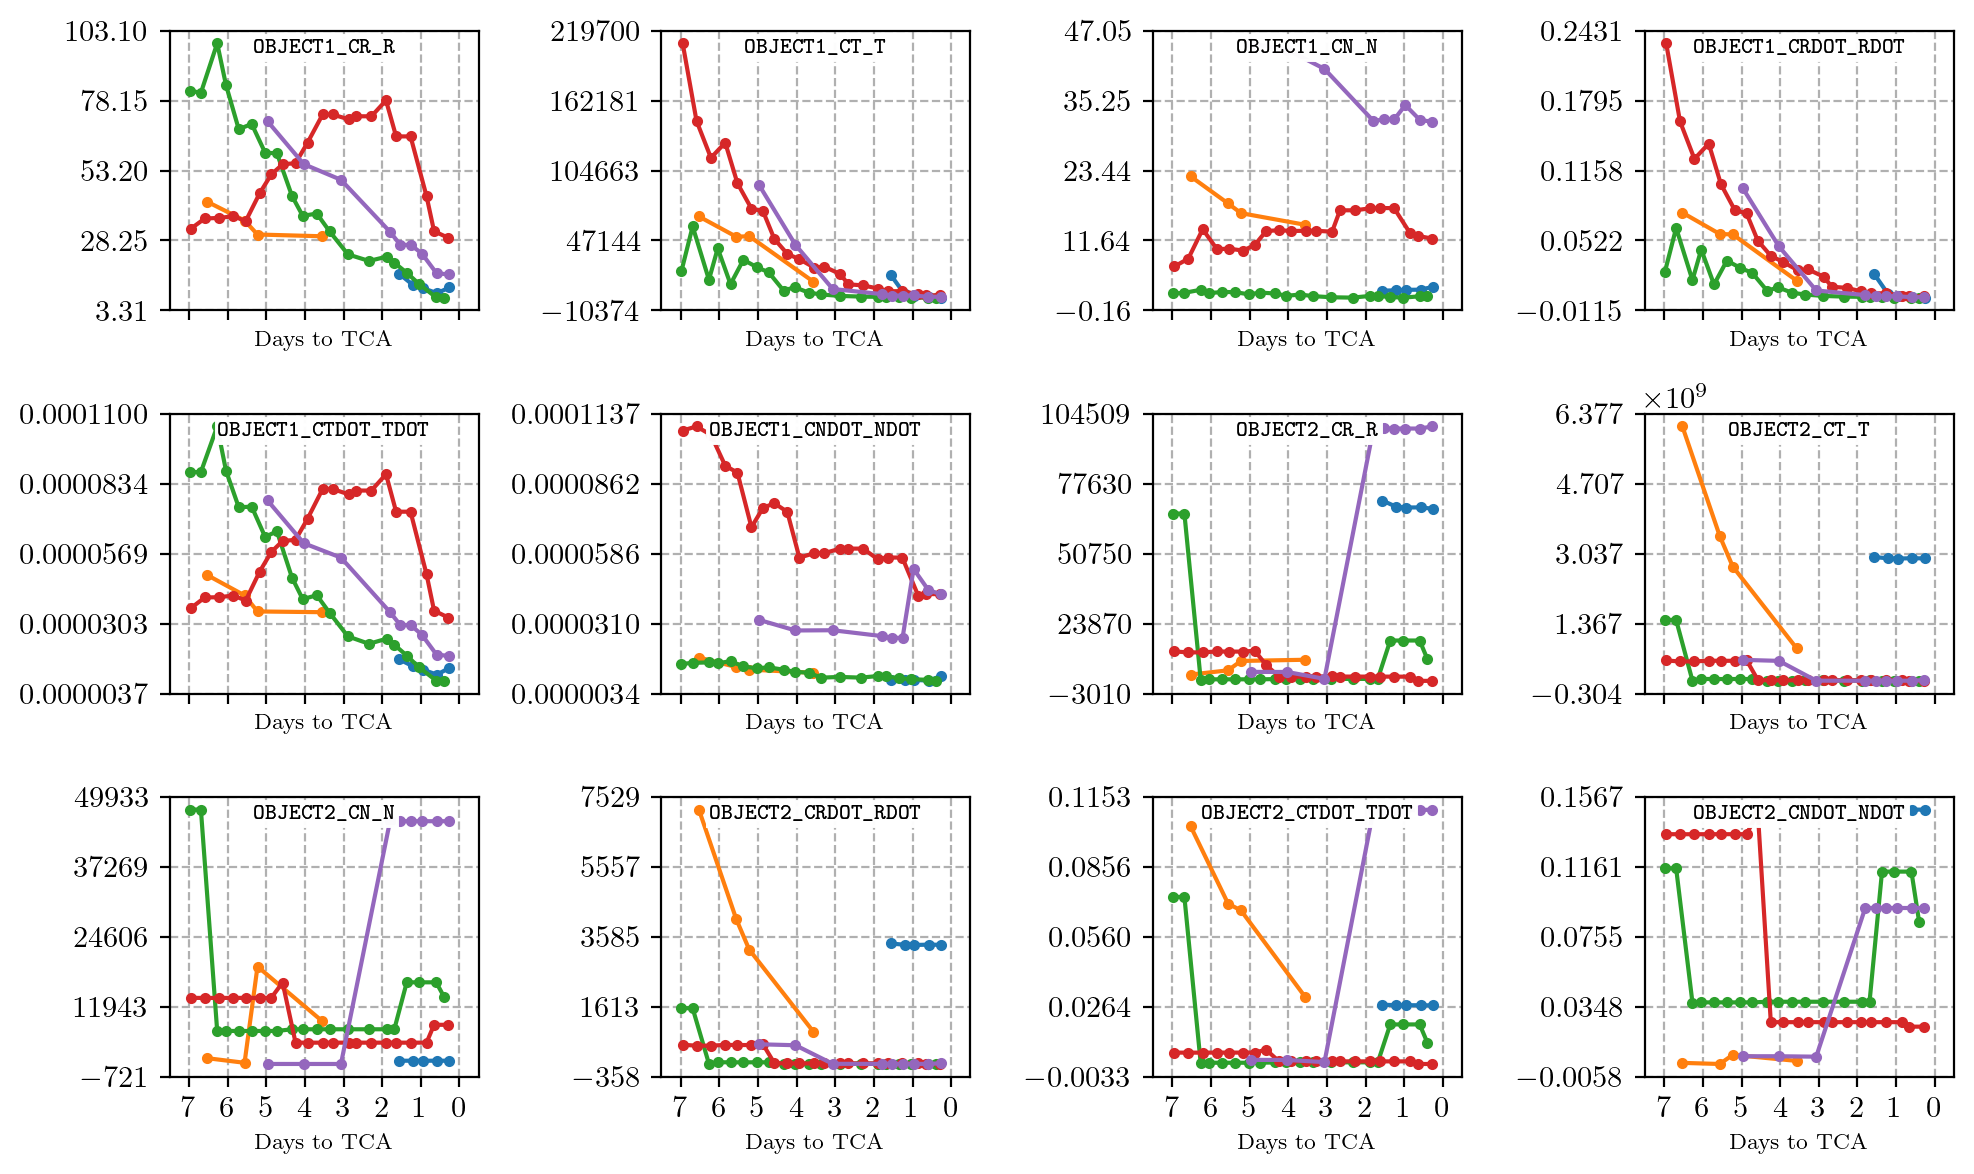

In [17]:
# Plot main diagonal of the covariance matrix
events[:5].plot_uncertainty(diagonal = True, figsize=(10,6))

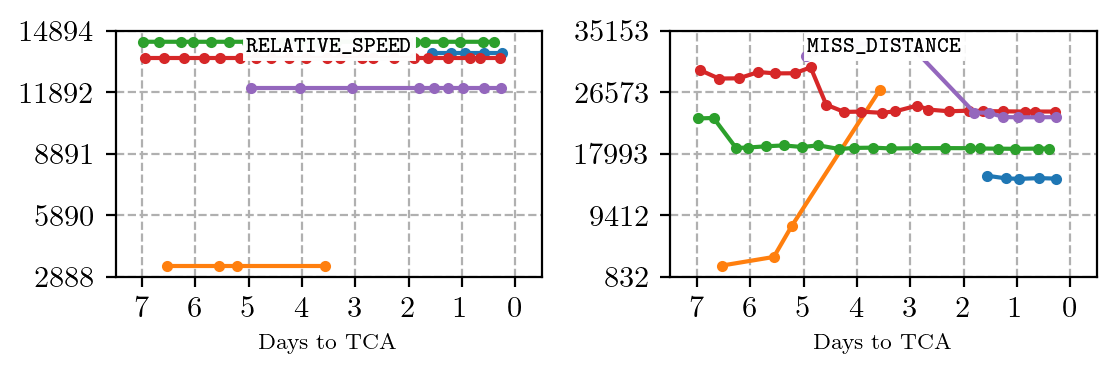

In [18]:
# Plot features evolutions
features = ['RELATIVE_SPEED', 'MISS_DISTANCE']
events[:5].plot_features(features = features)

### 2.2.- Split data into train, validation and test subsets

In [4]:
# Get features to train the model
nn_features = events.common_features(only_numeric=True)
nn_features = [f for f in nn_features if f!='COLLISION_PROBABILITY']

# Get input and output size of the model
input_size = output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set = int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test = events[-len_test_set:]
print('\nTest data:\n', events_test)

# Get events used for training and validation:
# - Training set   - Used to train the model.
# - Validation set - Used to fine tune hyperparameters.
events_train = events[:-len_test_set]
print('\nTraining and validation data:\n', events_train)


CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:37s |   52.73   | Pandas DataFrame saved.                                 

Test data:
 ConjunctionEventsDataset(Events: 100 | CDMs per event: 1 (min), 22 (max), 12.80 (mean))

Training and validation data:
 ConjunctionEventsDataset(Events: 1900 | CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Conjunction Event forecasting model configuration

### 3.1.- Recurrent Neural Network configuration <a name="introduction"></a>

In [8]:
# Import modules required to set up the neural network configuration
import torch.nn as nn
import scapy.layers as layers
import scapy.cells as cell

# Configure first set of layer(s)
layer = layers.GU(input_size = input_size,  # Inputs of the layer
                  batch_first = True,       # Batched
                  hidden_size = 900,        # Hidden neurons
                  num_layers = 1,           # Stacked layers
                  dropout = 0.05,           # Dropout probability
                  cell = cell.GRU_SLIMX,    # Cell variant
                  **dict(version = 3)       # Cell variant version
                  )

# Define network configuration using the ModuleDict class from pytorch.
# WARNING! LSTM, GRU and MGU layers should be named as 'lstm', 'gru' and 'mgu'
#          respectively in the ModuleDict class.
network = nn.ModuleDict({'gru': layer,
                        'dropout': nn.Dropout(p = 0.05),
                        'relu': nn.ReLU(),
                        'linear': nn.Linear(layer.hidden_size, output_size)
                        })

# Print network
print(network)

ModuleDict(
  (gru): GU(
    (layers): ModuleList(
      (0): RNNLayer(
        (cell): GRU_SLIMX(
          (_sigmoid): Sigmoid()
          (_tanh): Tanh()
          (gate_update_h): Bias()
          (gate_reset_h): Bias()
          (gate_hidden_x): Linear(in_features=66, out_features=900, bias=False)
          (gate_hidden_h): Linear(in_features=900, out_features=900, bias=True)
        )
      )
    )
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (linear): Linear(in_features=900, out_features=66, bias=True)
)


### 3.2.- Model instanciation

In [9]:
# Import module for conjunction event forecasting model
from scapy.cef import ConjunctionEventForecaster as cef

# Initialize model with the network.
model = cef(network = network, features = nn_features)

# Show model parameters
print(model)

ConjunctionEventForecaster(
  (model): ModuleDict(
    (gru): GU(
      (layers): ModuleList(
        (0): RNNLayer(
          (cell): GRU_SLIMX(
            (_sigmoid): Sigmoid()
            (_tanh): Tanh()
            (gate_update_h): Bias()
            (gate_reset_h): Bias()
            (gate_hidden_x): Linear(in_features=66, out_features=900, bias=False)
            (gate_hidden_h): Linear(in_features=900, out_features=900, bias=True)
          )
        )
      )
    )
    (dropout): Dropout(p=0.05, inplace=False)
    (relu): ReLU()
    (linear): Linear(in_features=900, out_features=66, bias=True)
  )
)


## 4.- Model loading and training

### 4.1.- Loading model (optional)

In [10]:
# Get model's filename where the parameters are saved
filepath = f'cef_gru_slim3_f66_1x900_parameters.pt'

# Check load parameters from previous trainings:
# WARNING! This step is only valid for models instanciated with exactly the same 
#          input parameters
if os.path.exists(filepath): 
    model.load(filepath = filepath)
else:
    print(f'Model parameters not found in {filepath}.')

Model parameters not found in cef_gru_slim3_f66_1x900_parameters.pt.


### 4.2.- Training model (optional if model is already trained)

In [11]:
# Train the RNN model
model.learn(event_set = events_train,           # List of events for training
            epochs = 10,                        # Number of epochs
            lr = 1e-3,                          # Initial learning rate
            batch_size = 15,                    # Number of batches
            device = 'cpu',                     # Tensors allocation device
            event_samples_for_stats = 500,      # Number of random samples used 
                                                # for normalisation
            filepath = filepath,                # Path where parameters of 
                                                # trained model are saved (.pt)
            epoch_step_checkpoint = 2           # Checkpoint epoch
            )

Number of learnable parameters of the model: 931,566

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (500/500)| 00h:00m:00s | 102001.56 | Pandas DataFrame saved.                                 

TRAINING FORECASTING MODEL:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1040/1040)| 00h:15m:01s |   1.15    | E(10/10) B(104/104) | Loss > T(5.8280e-02) V(1.3768e-01)

Saving model parameters ... Done.


### 4.3.- Saving model (optional)

In [12]:
# Additionally, the model has a buil-in method to save the parameters 
# (recommended - default) or the entire model.

model.save(filepath = filepath,     # Path where parameters are saved (.pt)
           only_parameters = True   # Flag to save only parameters.
           )

## 5.- Evaluating models performance using the Test dataset

In [13]:
# Model evaluation metrics:
# - SSE     (Sum of Squared Errors)
# - MSE     (Mean Squared Errors)
# - MAE     (Mean Absolute Errors)
# - MAPE    (Mean Absolute Percentage Errors)
# - POCID   (Proportion Of Change In Direction)
# - BIC     (Bayesian Information Criterion)

# Test model usinf the events_test dataset.
test_results = model.test(events_test = events_test,  # List of events for test
                          test_batch_size = 10        # Number of batches
                          )

In [14]:
# Import pandas to save results
import pandas as pd

# Convert dictionary to Pandas DataFrame (rows = batch, columns = networks).
df_test_results = pd.DataFrame.from_dict(data = test_results, orient='columns')
display(df_test_results)

# Save test results in a CSV file.
folderpath = os.path.join(cwd, 'notebooks', 'users', 'results')
if not os.path.exists(folderpath): utils.mkdirtree(folderpath)
df_test_results.to_csv(os.path.join(folderpath, 'test_results.csv'))

,sse,mse,mae,mape,bic,pocid
0,2722.833496,0.196453,0.174037,216591792.0,2.144994e+06,27.363636
1,1706.048462,0.123092,0.104104,326245760.0,2.144989e+06,16.696970
2,1280.507935,0.092389,0.137975,193332656.0,2.144986e+06,31.265152
3,1842.153687,0.132912,0.134356,352144928.0,2.144990e+06,20.893939
4,2967.655273,0.214117,0.154542,289545408.0,2.144995e+06,27.666667
5,1276.379639,0.092091,0.147844,203945360.0,2.144986e+06,36.757576
6,2633.335449,0.189995,0.173707,424285216.0,2.144993e+06,20.636364
7,4418.417969,0.318789,0.174874,402027200.0,2.144999e+06,23.666667
8,533.687988,0.038506,0.093069,251487424.0,2.144977e+06,24.159091
9,3369.260742,0.243092,0.194399,183935744.0,2.144996e+06,35.318182


## 6.- Using the model to forecast Conjunction Events

Forecasting next CDM from previous 21 CDM(s)...


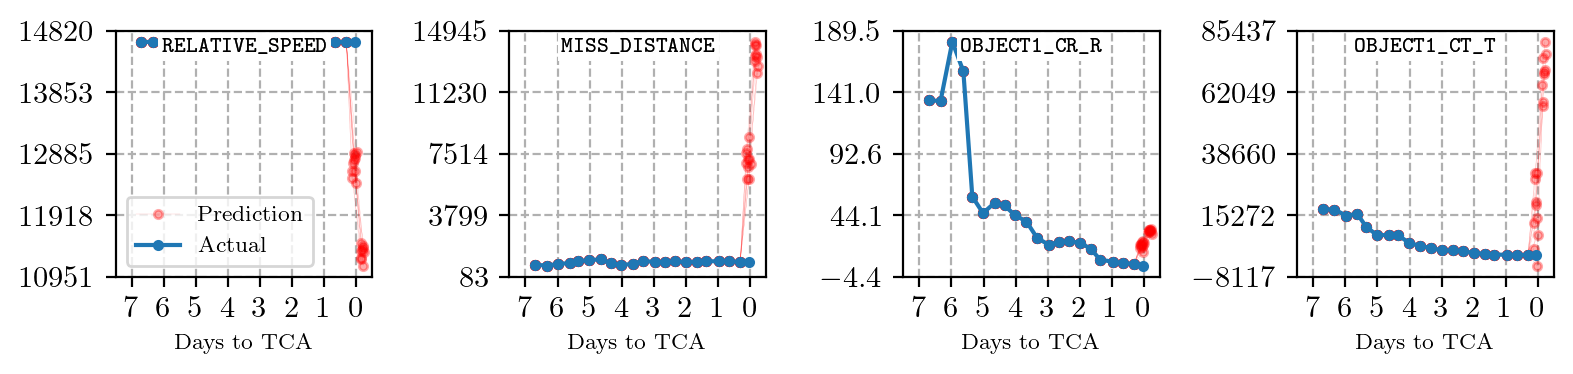

In [23]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
forecasts = model.predict_event(event = event_beginning, 
                                num_samples = 10, 
                                max_length = 14
                                )

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CR_R', 'OBJECT1_CT_T']

# Set keyword arguments for the plots
kwargs = dict(linewidth = 0.1, color= 'red', alpha = 0.33, label = 'Prediction')

# Plot forecasted values of features
axs_pred = forecasts.plot_features(features = features,
                                   figsize = (8, 2), 
                                   return_axs = True, 
                                   **kwargs
                                   )
# Plot true values of features in blue:
event.plot_features(features = features, 
                    axs = axs_pred, 
                    label = 'Actual', 
                    legend = True)